In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

In [3]:
import sys
sys.path.insert(0, "../")

In [4]:
from functools import reduce
from run_localise import get_target_weights
# the problem here is that this will return a fixed path
from main_rq1 import return_target_mdl_and_gt_path

In [46]:
import matplotlib.pyplot as plt

In [5]:
datadir = "../data"
root_faulty_mdl_dir = os.path.join(datadir, "models/faulty_models/by_tweak/chg/0_001/mv")
faulty_mdl_dirs = {'cifar10':os.path.join(root_faulty_mdl_dir, "cifar10"), 
                  'fashion_mnist':os.path.join(root_faulty_mdl_dir, "fashion_mnist"),
                  'GTSRB':os.path.join(root_faulty_mdl_dir, "GTSRB")}

fid_files = {'cifar10':os.path.join(datadir,"rq1_fault_ids/cifar10.target.fault_ids.csv"),
             'fashion_mnist':os.path.join(datadir, "rq1_fault_ids/fm.target.fault_ids.csv"),
            'GTSRB':os.path.join(datadir, "rq1_fault_ids/gtsrb.target.fault_ids.csv")}

In [6]:
pairdirs = {'cifar10':"../results/rq1/new_loc/simple_cm/pairs", 
            'fashion_mnist':"../results/rq1/new_loc/simple_fm/pairs", 
           'GTSRB':"../results/rq1/new_loc/GTSRB/pairs"} 

tst_pairdirs = {'cifar10':"../results/rq1/new_loc/on_test/simple_cm/pairs", 
            'fashion_mnist':"../results/rq1/new_loc/on_test/simple_fm/pairs", 
           'GTSRB':"../results/rq1/new_loc/on_test/GTSRB/pairs"} 

In [7]:
num_faults = {'cifar10':40, 'fashion_mnist':31, 'GTSRB':35}
mdl_paths = {'cifar10':"../data/models/cifar_simple_90p.h5", 
           'fashion_mnist':"../data/models/fmnist_simple.h5",
            'GTSRB':"../data/models/GTSRB_NEW/simple/gtsrb.model.0.wh.0.h5"}

# What can we check

1. gradient loss of ground truth neural weights and the localisation effectiveness (rank) 
    - check whether they are correlated
    - we have inserted faults randomly, but the search process (i.e., finding the ones that could change the behaviour of a DNN model significantly) might indirectly direct the search towards the neural with higher grandient loss) 
    - changes != incorrect behaviour (we consider all types of changes here, both fix and fault) 
2. per layer analysis -> Done
3. the distance from the normal distribution of weights and the localisation effectivenss
    - check the correlation (plot them -> how they are correlated -> If shows a stronger correlation, the corresponding localisation method is simply choosing a neural weight far from the normal distribution) 
    - e.g., if they are correlated, then this means that .... 

In [28]:
def get_loc_result(which_data, loc_method, num_samples = 1, seed = None, on_test = False):
    """
    loc_method: localiser, gradient_loss, random
    cost order: 
        ratio of chgd/unchgd for (gradient_loss, forward_impact) <- cost_from_chgd/(1. + cost_from_unchgd)
    """
    from glob import glob
    pairdir = os.path.join(
        pairdirs[which_data] if not on_test else tst_pairdirs[which_data], loc_method)
    
    if seed is None:
        np.random.seed(0)
        files = glob(os.path.join(pairdir, "*.pairs.csv"))
        indices = np.random.choice(np.arange(len(files)), 30, replace = False)
        files = [files[i] for i in indices]
    else:
        files = glob(os.path.join(pairdir, "{}.pairs.csv".format(seed)))
    
    dfs = {}
    for afile in tqdm(files):
        fid = int(os.path.basename(afile).split(".")[0])
        df = pd.read_csv(afile, sep = ";", header = None)
        dfs[fid] = df
        df[0] = [eval(v) for v in df[0]]
        df[1] = [eval(v.replace('array', 'np.array')) for v in df[1]]
    
    return dfs

In [27]:
def get_gts(seed, which_data):
    """
    """
    _, gt_file = return_target_mdl_and_gt_path(fid_files[which_data], seed, which_data)
    #print (gt_file)
    gts_df = pd.read_pickle(os.path.join("../", gt_file))
    
    gt_layers = gts_df.layer.values
    gt_weights = [tuple(w) for w in gts_df.w_idx.values]
    gts = list(zip(gt_layers, gt_weights))
    return gts, gts_df

In [11]:
def get_ranks_of_gts(loc_method, loc_result_df, gts, tie_method = 'average', ws = None):
    """
    """
    check = lambda vs, target_v: [v[0] == target_v for v in vs]
    ranks_of_gts = {}
    
    if loc_method == "localiser":
        ## 
        uniq_sizes_of_pareto = sorted(list(set([vs[0] for vs in loc_result_df[1].values])))
        for gt in gts:
            #r_of_gt = loc_result_df.loc[loc_result_df[0] == gt][1].values[0][0] # the firt matched & the rank
            max_rank_of_gt = loc_result_df.loc[loc_result_df[0] == gt][1].values[0][0] 
            nelems_to_front = max_rank_of_gt
            front_size = np.sum([loc_result_df[1].apply(lambda v:v[0]) == nelems_to_front])
            
            if tie_method == 'average':
                #ranks_of_gts[gt] = int(r_of_gt/2) if r_of_gt > 1 else r_of_gt
                ranks_of_gts[gt] = max_rank_of_gt - front_size/2 + 0.5
            elif tie_method == 'min':
                #idx = uniq_sizes_of_pareto.index(max_rank_of_gt)
                #if idx == 0:
                #    ranks_of_gts[gt] = 1
                #else:
                #    ranks_of_gts[gt] = uniq_sizes_of_pareto[idx-1] + 1
                ranks_of_gts[gt] = max_rank_of_gt - front_size + 1
            elif tie_method == 'max':
                ranks_of_gts[gt] = max_rank_of_gt
                
    elif loc_method == 'gradient_loss':
        for gt in gts:
            max_rank_of_gt = loc_result_df.loc[loc_result_df[0] == gt][1].values[0][0] # for max 
            
            if tie_method in ['average', 'min']:
                num_has_same_r = len(loc_result_df.loc[check(loc_result_df[1].values, max_rank_of_gt)][1].values)
                max_rank_of_gt = max_rank_of_gt + (num_has_same_r - 1)/2 if tie_method == 'average' \
                    else max_rank_of_gt - (num_has_same_r-1)
            
            ranks_of_gts[gt] = max_rank_of_gt
    else: # random
        assert ws is not None
        from functools import reduce
        num_ws = np.sum([reduce(np.multiply, w[0].shape) for w in ws.values()])
        sampled_ranks = np.random.choice(range(num_ws), len(gts), replace = False)
        for gt, r in zip(gts, sampled_ranks):
            ranks_of_gts[gt] = r
            
    return ranks_of_gts

In [29]:
def compute_tpr_fpr(gt_ranks, which_data, mdl_path, indices_to_target = None):
    """
    gt_ranks -> ranks up to gts 
    gts: a list of ground trith (layer_idx, weight idx)
    """
    from sklearn.metrics import auc
    
    ws = get_target_weights(None, mdl_path, indices_to_target = indices_to_target, target_all = True)
    uniq_layers = sorted(list(ws.keys()))
    all_pos_ranks = np.arange(1, np.sum(
        [reduce(np.multiply, ws[uniq_layer][0].shape) for uniq_layer in uniq_layers])+1)
    
    seeds = sorted(list(gt_ranks.keys()))
    num_iter = len(seeds)
    
    # for each iter, compute tpr and fpr
    tprs_per_iter = np.zeros((len(all_pos_ranks), num_iter))
    fprs_per_iter = np.zeros((len(all_pos_ranks), num_iter))
    for i, seed in enumerate(tqdm(seeds)):
        gts, _ = get_gts(seed, which_data)
        r_gts = np.asarray([gt_ranks[seed][gt] for gt in gts])   
        N = len(all_pos_ranks) - len(r_gts)
        for j, arank in enumerate(all_pos_ranks):
            n_tp = np.sum(r_gts <= arank)
            tpr = n_tp/len(gts)
            n_fp = arank - n_tp
            fpr = n_fp/N
            
            tprs_per_iter[j,i] = tpr
            fprs_per_iter[j,i] = fpr
        
    return {'x':all_pos_ranks, 'tpr':tprs_per_iter, 'fpr':fprs_per_iter}

In [252]:
def get_layers_with_fault(which_data, iter_indices = np.arange(30)):
    """
    """
    layers = []; players ={}
    for iter_idx in iter_indices:
        gts, _ = get_gts(iter_idx, which_data)
        layers.extend([gt[0] for gt in gts])
        players[iter_idx] = [gt[0] for gt in gts][0]
    layers = set(layers)
    return sorted(list(layers)), players

In [ ]:
def plot_tpr_fpr_v1(tprs_diffloc, fprs_diffloc, loc_methods, colors, 
                    figsize = (8,6), title = None, file_path = None, cut = False):
    """
    """
    import matplotlib.pyplot as plt
    
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot(111)
    
    if cut:
        ats_tpr_to_1 = [np.where(np.mean(tprs_diffloc[loc_method],axis=1)==1)[0][0] for loc_method in loc_methods]
        at_all_tpr_to_1 = np.min(ats_tpr_to_1)
    else:
        at_all_tpr_to_1 = None
    
    for loc_method, color in zip(loc_methods, colors):
        tprs = tprs_diffloc[loc_method] if at_all_tpr_to_1 is None else tprs_diffloc[loc_method][:at_all_tpr_to_1+1]
        fprs = fprs_diffloc[loc_method] if at_all_tpr_to_1 is None else fprs_diffloc[loc_method][:at_all_tpr_to_1+1]
        
        mean_tpr_per_iter = np.mean(tprs, axis = 1) # will be ys
        mean_fpr_per_iter = np.mean(fprs, axis = 1) # will be xs
        ax.plot(mean_fpr_per_iter, mean_tpr_per_iter, 
                color = color, linestyle='solid', label = loc_method) #marker='o', ms = 0.1,
    
    #print (at_all_tpr_to_1, mean_fpr_per_iter[at_all_tpr_to_1])
    if cut:
        ax.set_xlim([None, mean_fpr_per_iter[at_all_tpr_to_1]])#+0.002])
    ax.set_xlabel("False Positive Rate", fontsize = 15)
    ax.set_ylabel("True Postivie Rate",  fontsize = 15)
    
    if title is not None:
        ax.set_title(title, fontsize = 18)
    
    if file_path is not None:
        plt.savefig(file_path)
        
    plt.legend(prop={'size': 12})
    plt.show()

In [79]:
def compute_tpr_fpr_to_plot(outs):
    """
    """
    tpr_vs = np.apply_along_axis(lambda v:np.sum(v)/len(v), 0, outs['tpr'].T)
    fpr_vs = np.apply_along_axis(lambda v:np.sum(v)/len(v), 0, outs['fpr'].T)
    
    return tpr_vs, fpr_vs

In [243]:
def plot(tprs_fprs, title, figsize = (8,6), file_name = None):
    """
    """
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot(111)
    
    ax.plot(tprs_fprs['localiser']['fpr'], tprs_fprs['localiser']['tpr'], c = 'red', label = 'BL')
    ax.plot(tprs_fprs['gradient_loss']['fpr'], tprs_fprs['gradient_loss']['tpr'], c = 'blue', label = 'GL')
    ax.plot(tprs_fprs['random']['fpr'], tprs_fprs['random']['tpr'], c = 'green', label = 'RD')
    
    ax.set_xlabel("False Positive Rate", fontsize = 26)
    ax.set_ylabel("True Positive Rate", fontsize = 27)
    #ax.set_title(title, fontsize = 20)
    
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    plt.legend(fontsize = 26)
    plt.tight_layout()
    if file_name is not None:
        plt.savefig(file_name)
    
    plt.show()

In [103]:
def compute_MRR(rs):
    """
    """
    return np.mean([1/r for r in rs])

In [133]:
def compute_auc_roc_score(fprs, tprs):
    from sklearn.metrics import auc
    return auc(fprs, tprs)

In [201]:
def get_ranks(loc_results, loc_methods = ['localiser', 'gradient_loss', 'random']):
    """
    """
    ranks = {}
    for loc_mth in loc_methods:
        ranks[loc_mth] = []
        for vs in loc_results[loc_mth].values():
            w, r = list(vs.items())[0]
            ranks[loc_mth].append(r)
    return ranks

# Evaluation

In [34]:
weights = {}
for k in ['cifar10', 'fashion_mnist', 'GTSRB']:
    weights[k] = get_target_weights(None, mdl_paths[k], indices_to_target = None, target_all = True)

## Fashion MNIST

In [222]:
## on test
which_data = 'fashion_mnist'
tie_method = 'average' #'average'

tst_fm_loc_results = get_loc_result(
    which_data, 'localiser', num_samples = 1, seed = None, on_test = True)

tst_fm_loc_gl_results = get_loc_result(
    which_data, 'gradient_loss', num_samples = 1, seed = None, on_test = True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  9.43it/s]


In [223]:
fm_gt_ranks_per_locmth = {'localiser':{}, 'gradient_loss':{}, 'random':{}}

seeds = list(tst_fm_loc_results.keys()) # because, the fault injection wasn't always successful 
for seed in seeds:
    gts, _ = get_gts(seed, which_data)
    
    fm_gt_ranks_per_locmth['localiser'][seed] = get_ranks_of_gts(
        'localiser', tst_fm_loc_results[seed], gts, tie_method = tie_method)
    
    fm_gt_ranks_per_locmth['gradient_loss'][seed] = get_ranks_of_gts(
        'gradient_loss', tst_fm_loc_gl_results[seed], gts, tie_method = tie_method)
    
    fm_gt_ranks_per_locmth['random'][seed] = get_ranks_of_gts(
        'random', None, gts, tie_method = tie_method, ws = weights[which_data])

In [144]:
fm_outs_loc = compute_tpr_fpr(
    fm_gt_ranks_per_locmth['localiser'], which_data, mdl_paths[which_data])
fm_outs_gl = compute_tpr_fpr(
    fm_gt_ranks_per_locmth['gradient_loss'], which_data, mdl_paths[which_data])
fm_outs_rd = compute_tpr_fpr(
    fm_gt_ranks_per_locmth['random'], which_data, mdl_paths[which_data])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.83it/s]


In [145]:
fm_tprs_fprs = {'localiser':{}, 'gradient_loss':{}, 'random':{}}

fm_tprs_fprs['localiser']['tpr'], fm_tprs_fprs['localiser']['fpr'] = compute_tpr_fpr_to_plot(fm_outs_loc)
fm_tprs_fprs['gradient_loss']['tpr'], fm_tprs_fprs['gradient_loss']['fpr'] = compute_tpr_fpr_to_plot(fm_outs_gl)
fm_tprs_fprs['random']['tpr'], fm_tprs_fprs['random']['fpr'] = compute_tpr_fpr_to_plot(fm_outs_rd)

In [146]:
import pickle
os.makedirs("../results/rq1/new_loc/on_test/simple_fm/tpr_fpr", exist_ok = True)
if tie_method == 'max':
    dest_file = "../results/rq1/new_loc/on_test/simple_fm/tpr_fpr/fm_tie_max.pkl"
else:
    dest_file = "../results/rq1/new_loc/on_test/simple_fm/tpr_fpr/fm.pkl"
    
with open(dest_file, 'wb') as f:
    pickle.dump(fm_tprs_fprs, f)

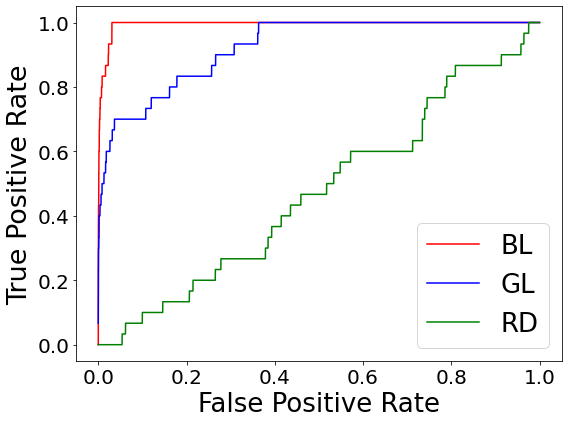

In [244]:
if tie_method == 'max':
    file_name = "/Users/jeongju.sohn/workdir/Journals/autopatch_nn_icse20/figures/rev/rq1/fm_tie_max.pdf"
else:
    file_name = "/Users/jeongju.sohn/workdir/Journals/autopatch_nn_icse20/figures/rev/rq1/fm.pdf"
plot(fm_tprs_fprs, "ROC Curve per FL strategy (Fashion-MNIST)", figsize = (8,6), file_name = file_name)

localiser: 2.0~2386.5, 418.6666666666667(avg), 552.0(med)
gradient_loss: 1.0~28842.0, 6058.233333333334(avg), 552.0(med)
random: 4284~77434, 41876.8(avg), 552.0(med)


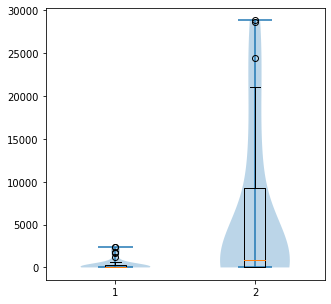

In [224]:
loc_methods = ['localiser', 'gradient_loss', 'random']

fm_ranks = get_ranks(fm_gt_ranks_per_locmth, loc_methods = loc_methods)
for loc_mth in loc_methods:
    rs = fm_ranks[loc_mth]
    print ("{}: {}~{}, {}(avg), {}(med)".format(loc_mth, np.min(rs), np.max(rs), np.mean(rs), np.median(r)))


fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
ax.boxplot([fm_ranks['localiser'], fm_ranks['gradient_loss']])
ax.violinplot([fm_ranks['localiser'], fm_ranks['gradient_loss']])
plt.show()

In [169]:
with open("../results/rq1/new_loc/on_test/simple_fm/tpr_fpr/fm_tie_max.pkl", 'rb') as f:
    fm_ranks_max = pickle.load(f)
    
with open("../results/rq1/new_loc/on_test/simple_fm/tpr_fpr/fm.pkl", 'rb') as f:
    fm_ranks_avg = pickle.load(f)

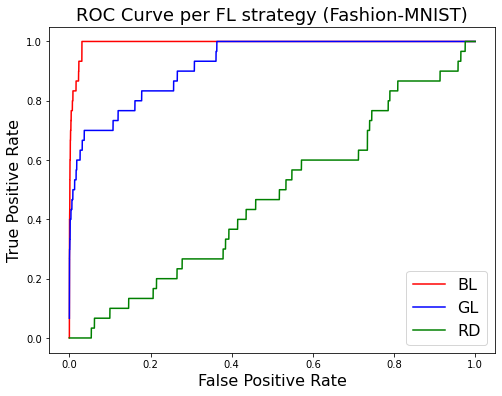

In [172]:
plot(fm_ranks_max, "ROC Curve per FL strategy (Fashion-MNIST)", figsize = (8,6))

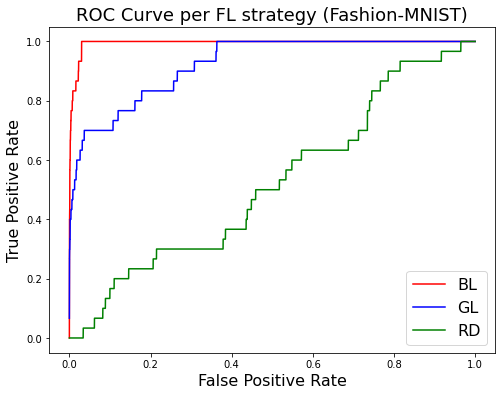

In [173]:
plot(fm_ranks_avg, "ROC Curve per FL strategy (Fashion-MNIST)", figsize = (8,6))

In [137]:
for loc_mth in ['localiser', 'gradient_loss', 'random']:
    auc_roc_score = compute_auc_roc_score(fm_tprs_fprs[loc_mth]['fpr'], fm_tprs_fprs[loc_mth]['tpr'])
    rs = [list(vs.values())[0] for vs in fm_gt_ranks_per_locmth[loc_mth].values()]
    mrr_score = compute_MRR(rs)
    
    print (loc_mth, np.round(auc_roc_score, decimals=3), np.round(mrr_score, decimals = 3))

localiser 0.995 0.079
gradient_loss 0.924 0.096
random 0.521 0.0


In [152]:
# tie method = 'max'
for loc_mth in ['localiser', 'gradient_loss', 'random']:
    auc_roc_score = compute_auc_roc_score(fm_tprs_fprs[loc_mth]['fpr'], fm_tprs_fprs[loc_mth]['tpr'])
    rs = [list(vs.values())[0] for vs in fm_gt_ranks_per_locmth[loc_mth].values()]
    mrr_score = compute_MRR(rs)
    
    print (loc_mth, np.round(auc_roc_score, decimals=3), np.round(mrr_score, decimals = 3))

localiser 0.995 0.052
gradient_loss 0.924 0.096
random 0.473 0.0


### within layers with faulty neural weights

In [254]:
fm_uniq_layers, fm_player_ws = get_layers_with_fault('fashion_mnist', iter_indices = np.arange(30))
fm_player_ws

{0: 3,
 1: 3,
 2: 3,
 3: 3,
 4: 3,
 5: 3,
 6: 3,
 7: 3,
 8: 3,
 9: 3,
 10: 3,
 11: 3,
 12: 3,
 13: 3,
 14: 1,
 15: 3,
 16: 3,
 17: 1,
 18: 3,
 19: 3,
 20: 1,
 21: 1,
 22: 1,
 23: 3,
 24: 1,
 25: 1,
 26: 3,
 27: 1,
 28: 1,
 29: 1}

## CIFAR10

In [225]:
## on test
which_data = 'cifar10'
tie_method = 'average' #'average'

# get complete fault localisation results
tst_c10_loc_results = get_loc_result(
    which_data, 'localiser', num_samples = 1, seed = None, on_test = True)

tst_c10_loc_gl_results = get_loc_result(
    which_data, 'gradient_loss', num_samples = 1, seed = None, on_test = True)

# get ranks of faulty neural weights
c10_gt_ranks_per_locmth = {'localiser':{}, 'gradient_loss':{}, 'random':{}}

seeds = list(tst_c10_loc_results.keys()) # because, the fault injection wasn't always successful 
for seed in seeds:
    gts, _ = get_gts(seed, which_data)
    
    c10_gt_ranks_per_locmth['localiser'][seed] = get_ranks_of_gts(
        'localiser', tst_c10_loc_results[seed], gts, tie_method = tie_method)
    
    c10_gt_ranks_per_locmth['gradient_loss'][seed] = get_ranks_of_gts(
        'gradient_loss', tst_c10_loc_gl_results[seed], gts, tie_method = tie_method)
    
    c10_gt_ranks_per_locmth['random'][seed] = get_ranks_of_gts(
        'random', None, gts, tie_method = tie_method, ws = weights[which_data])
    
# comput tpr and fpr
c10_outs_loc = compute_tpr_fpr(
    c10_gt_ranks_per_locmth['localiser'], which_data, mdl_paths[which_data])
c10_outs_gl = compute_tpr_fpr(
    c10_gt_ranks_per_locmth['gradient_loss'], which_data, mdl_paths[which_data])
c10_outs_rd = compute_tpr_fpr(
    c10_gt_ranks_per_locmth['random'], which_data, mdl_paths[which_data])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:55<00:00,  3.85s/it]


In [149]:
c10_tprs_fprs = {'localiser':{}, 'gradient_loss':{}, 'random':{}}

c10_tprs_fprs['localiser']['tpr'], c10_tprs_fprs['localiser']['fpr'] = compute_tpr_fpr_to_plot(c10_outs_loc)
c10_tprs_fprs['gradient_loss']['tpr'], c10_tprs_fprs['gradient_loss']['fpr'] = compute_tpr_fpr_to_plot(c10_outs_gl)
c10_tprs_fprs['random']['tpr'], c10_tprs_fprs['random']['fpr'] = compute_tpr_fpr_to_plot(c10_outs_rd)

In [150]:
import pickle
os.makedirs("../results/rq1/new_loc/on_test/simple_cm/tpr_fpr", exist_ok = True)
if tie_method == 'max':
    dest_file = "../results/rq1/new_loc/on_test/simple_cm/tpr_fpr/c10_tie_max.pkl"
else:
    dest_file = "../results/rq1/new_loc/on_test/simple_cm/tpr_fpr/c10.pkl"
    
with open(dest_file, 'wb') as f:
    pickle.dump(c10_tprs_fprs, f)

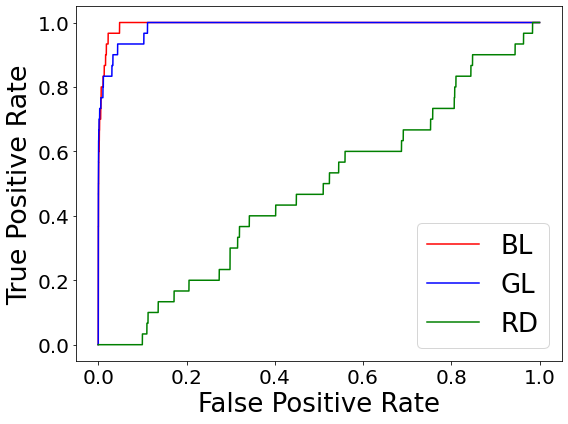

In [245]:
if tie_method == 'max':
    file_name = "/Users/jeongju.sohn/workdir/Journals/autopatch_nn_icse20/figures/rev/rq1/c10_tie_max.pdf"
else:
    file_name = "/Users/jeongju.sohn/workdir/Journals/autopatch_nn_icse20/figures/rev/rq1/c10.pdf"
    
plot(c10_tprs_fprs, "ROC Curve per FL strategy (CIFAR-10)", figsize = (8,6), file_name = file_name)

localiser: 3.0~25354.0, 2786.7166666666667(avg), 552.0(med)
gradient_loss: 8.0~59043.0, 6352.133333333333(avg), 552.0(med)
random: 52911~521391, 274998.8333333333(avg), 552.0(med)


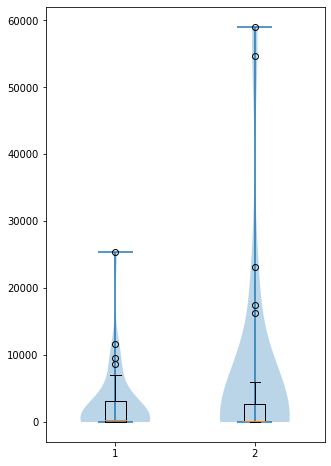

In [226]:
loc_methods = ['localiser', 'gradient_loss', 'random']

c10_ranks = get_ranks(c10_gt_ranks_per_locmth, loc_methods = loc_methods)
for loc_mth in loc_methods:
    rs = c10_ranks[loc_mth]
    print ("{}: {}~{}, {}(avg), {}(med)".format(loc_mth, np.min(rs), np.max(rs), np.mean(rs), np.median(r)))


fig = plt.figure(figsize = (5,8))
ax = fig.add_subplot(111)
ax.boxplot([c10_ranks['localiser'], c10_ranks['gradient_loss']])
ax.violinplot([c10_ranks['localiser'], c10_ranks['gradient_loss']])
plt.show()

In [138]:
for loc_mth in ['localiser', 'gradient_loss', 'random']:
    auc_roc_score = compute_auc_roc_score(c10_tprs_fprs[loc_mth]['fpr'], c10_tprs_fprs[loc_mth]['tpr'])
    rs = [list(vs.values())[0] for vs in c10_gt_ranks_per_locmth[loc_mth].values()]
    mrr_score = compute_MRR(rs)
    
    print (loc_mth, np.round(auc_roc_score, decimals=3), np.round(mrr_score, decimals = 3))

localiser 0.995 0.055
gradient_loss 0.988 0.018
random 0.481 0.0


In [153]:
# tie method = 'max'
for loc_mth in ['localiser', 'gradient_loss', 'random']:
    auc_roc_score = compute_auc_roc_score(c10_tprs_fprs[loc_mth]['fpr'], c10_tprs_fprs[loc_mth]['tpr'])
    rs = [list(vs.values())[0] for vs in c10_gt_ranks_per_locmth[loc_mth].values()]
    mrr_score = compute_MRR(rs)
    
    print (loc_mth, np.round(auc_roc_score, decimals=3), np.round(mrr_score, decimals = 3))

localiser 0.995 0.032
gradient_loss 0.988 0.018
random 0.481 0.0


In [164]:
# per layer
rs = {}
for vs in c10_gt_ranks_per_locmth['localiser'].values():
    w, r = list(vs.items())[0]
    if w[0] not in rs.keys():
        rs[w[0]] = []
    rs[w[0]].append(r)

In [166]:
compute_MRR(rs[9]), compute_MRR(rs[2])

(0.10515810817534955, 0.00597198423077015)

### within layers with faulty neural weights

In [256]:
c10_uniq_layers, c10_player_ws = get_layers_with_fault('cifar10', iter_indices = np.arange(30))
c10_uniq_layers, c10_player_ws

([2, 9],
 {0: 2,
  1: 2,
  2: 2,
  3: 2,
  4: 2,
  5: 2,
  6: 2,
  7: 2,
  8: 2,
  9: 2,
  10: 2,
  11: 2,
  12: 2,
  13: 2,
  14: 2,
  15: 2,
  16: 2,
  17: 2,
  18: 9,
  19: 9,
  20: 9,
  21: 2,
  22: 2,
  23: 2,
  24: 9,
  25: 9,
  26: 9,
  27: 2,
  28: 9,
  29: 9})

## GTSRB

In [227]:
## on test
which_data = 'GTSRB'
tie_method = 'average'

# get complete fault localisation results
tst_gtsrb_loc_results = get_loc_result(
    which_data, 'localiser', num_samples = 1, seed = None, on_test = True)

tst_gtsrb_loc_gl_results = get_loc_result(
    which_data, 'gradient_loss', num_samples = 1, seed = None, on_test = True)

# get ranks of faulty neural weights
gtsrb_gt_ranks_per_locmth = {'localiser':{}, 'gradient_loss':{}, 'random':{}}

seeds = list(tst_gtsrb_loc_results.keys()) # because, the fault injection wasn't always successful 
for seed in seeds:
    gts, _ = get_gts(seed, which_data)
    
    gtsrb_gt_ranks_per_locmth['localiser'][seed] = get_ranks_of_gts(
        'localiser', tst_gtsrb_loc_results[seed], gts, tie_method = tie_method)
    
    gtsrb_gt_ranks_per_locmth['gradient_loss'][seed] = get_ranks_of_gts(
        'gradient_loss', tst_gtsrb_loc_gl_results[seed], gts, tie_method = tie_method)
    
    gtsrb_gt_ranks_per_locmth['random'][seed] = get_ranks_of_gts(
        'random', None, gts, tie_method = tie_method, ws = weights[which_data])
    
# comput tpr and fpr
gtsrb_outs_loc = compute_tpr_fpr(
    gtsrb_gt_ranks_per_locmth['localiser'], which_data, mdl_paths[which_data])
gtsrb_outs_gl = compute_tpr_fpr(
    gtsrb_gt_ranks_per_locmth['gradient_loss'], which_data, mdl_paths[which_data])
gtsrb_outs_rd = compute_tpr_fpr(
    gtsrb_gt_ranks_per_locmth['random'], which_data, mdl_paths[which_data])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [15:06<00:00, 30.21s/it]


In [189]:
gtsrb_gt_ranks_per_locmth['localiser'].values()

dict_values([{(1, (1, 1, 0, 7)): 12}, {(1, (0, 0, 1, 9)): 117}, {(1, (2, 1, 1, 14)): 179}, {(1, (2, 2, 2, 14)): 663}, {(1, (1, 2, 0, 7)): 307}, {(1, (2, 0, 0, 14)): 653}, {(1, (0, 0, 2, 13)): 239}, {(1, (1, 0, 2, 9)): 90}, {(1, (2, 0, 0, 14)): 101}, {(1, (1, 0, 1, 10)): 104}, {(1, (2, 1, 1, 14)): 184}, {(1, (1, 0, 2, 10)): 402}, {(1, (2, 2, 2, 14)): 241}, {(1, (1, 2, 1, 7)): 368}, {(1, (2, 0, 0, 7)): 101}, {(1, (0, 0, 2, 10)): 200}, {(1, (0, 2, 1, 7)): 32}, {(1, (1, 1, 0, 7)): 113}, {(1, (2, 0, 0, 7)): 98}, {(1, (1, 2, 1, 7)): 363}, {(1, (1, 1, 0, 7)): 38}, {(1, (0, 0, 1, 9)): 73}, {(1, (2, 1, 1, 9)): 22}, {(1, (2, 0, 2, 14)): 374}, {(1, (1, 2, 2, 14)): 586}, {(1, (1, 0, 2, 10)): 185}, {(1, (1, 2, 0, 14)): 90}, {(1, (1, 2, 0, 9)): 126}, {(1, (0, 0, 0, 14)): 34}, {(1, (0, 2, 2, 9)): 93}])

In [182]:
gtsrb_tprs_fprs = {'localiser':{}, 'gradient_loss':{}, 'random':{}}

gtsrb_tprs_fprs['localiser']['tpr'], gtsrb_tprs_fprs['localiser']['fpr'] = compute_tpr_fpr_to_plot(gtsrb_outs_loc)
gtsrb_tprs_fprs['gradient_loss']['tpr'], gtsrb_tprs_fprs['gradient_loss']['fpr'] = compute_tpr_fpr_to_plot(gtsrb_outs_gl)
gtsrb_tprs_fprs['random']['tpr'], gtsrb_tprs_fprs['random']['fpr'] = compute_tpr_fpr_to_plot(gtsrb_outs_rd)


In [183]:
import pickle
os.makedirs("../results/rq1/new_loc/on_test/gtsrb/tpr_fpr", exist_ok = True)
if tie_method == 'max':
    dest_file = "../results/rq1/new_loc/on_test/gtsrb/tpr_fpr/gtsrb_tie_max.pkl"
else:
    dest_file = "../results/rq1/new_loc/on_test/gtsrb/tpr_fpr/gtsrb.pkl"
with open(dest_file, 'wb') as f:
    pickle.dump(gtsrb_tprs_fprs, f)

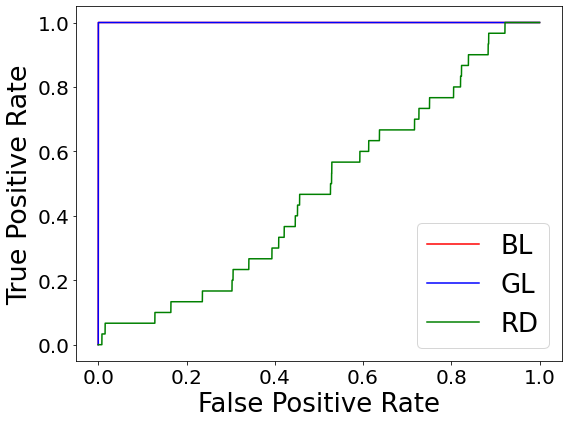

In [246]:
if tie_method == 'max':
    file_name = "/Users/jeongju.sohn/workdir/Journals/autopatch_nn_icse20/figures/rev/rq1/gtsrb_tie_max.pdf"
else:
    file_name = "/Users/jeongju.sohn/workdir/Journals/autopatch_nn_icse20/figures/rev/rq1/gtsrb.pdf"
    
plot(gtsrb_tprs_fprs, "ROC Curve per FL strategy (GTSRB)", figsize = (8,6), file_name = file_name)

localiser: 6.5~632.5, 188.26666666666668(avg), 552.0(med)
gradient_loss: 2.0~193.0, 60.13333333333333(avg), 552.0(med)
random: 35440~4014218, 2276256.8(avg), 552.0(med)


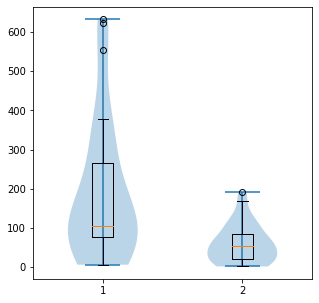

In [228]:
loc_methods = ['localiser', 'gradient_loss', 'random']

gtsrb_ranks = get_ranks(gtsrb_gt_ranks_per_locmth, loc_methods = loc_methods)
for loc_mth in loc_methods:
    rs = gtsrb_ranks[loc_mth]
    print ("{}: {}~{}, {}(avg), {}(med)".format(loc_mth, np.min(rs), np.max(rs), np.mean(rs), np.median(r)))


fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
ax.boxplot([gtsrb_ranks['localiser'], gtsrb_ranks['gradient_loss']])
ax.violinplot([gtsrb_ranks['localiser'], gtsrb_ranks['gradient_loss']])

plt.savefig("/Users/jeongju.sohn/workdir/Journals/autopatch_nn_icse20/figures/rev/rq1/gtsrb_rank.pdf")
plt.show()

In [247]:
for loc_mth in ['localiser', 'gradient_loss', 'random']:
    auc_roc_score = compute_auc_roc_score(gtsrb_tprs_fprs[loc_mth]['fpr'], gtsrb_tprs_fprs[loc_mth]['tpr'])
    rs = [list(vs.values())[0] for vs in gtsrb_gt_ranks_per_locmth[loc_mth].values()]
    mrr_score = compute_MRR(rs)
    
    print (loc_mth, np.round(auc_roc_score, decimals=8), np.round(mrr_score, decimals = 8))

localiser 0.99995288 0.01812904
gradient_loss 0.99998642 0.05979532
random 0.47744537 1.93e-06


In [185]:
for loc_mth in ['localiser', 'gradient_loss', 'random']:
    auc_roc_score = compute_auc_roc_score(gtsrb_tprs_fprs[loc_mth]['fpr'], gtsrb_tprs_fprs[loc_mth]['tpr'])
    rs = [list(vs.values())[0] for vs in gtsrb_gt_ranks_per_locmth[loc_mth].values()]
    mrr_score = compute_MRR(rs)
    
    print (loc_mth, np.round(auc_roc_score, decimals=8), np.round(mrr_score, decimals = 8))

localiser 0.99995288 0.01252636
gradient_loss 0.99998642 0.05979532
random 0.47744537 1.93e-06


### within layers with faulty neural weights

In [257]:
gtsrb_uniq_layers, gtsrb_player_ws = get_layers_with_fault('GTSRB', iter_indices = np.arange(30))
gtsrb_uniq_layers, gtsrb_player_ws

([1],
 {0: 1,
  1: 1,
  2: 1,
  3: 1,
  4: 1,
  5: 1,
  6: 1,
  7: 1,
  8: 1,
  9: 1,
  10: 1,
  11: 1,
  12: 1,
  13: 1,
  14: 1,
  15: 1,
  16: 1,
  17: 1,
  18: 1,
  19: 1,
  20: 1,
  21: 1,
  22: 1,
  23: 1,
  24: 1,
  25: 1,
  26: 1,
  27: 1,
  28: 1,
  29: 1})

# Per layer

In [168]:
def compute_prec_per_layer(gt_ranks, ws, raw = False):
    """
    """
    from functools import reduce
    from sklearn.metrics import auc
    
    total_num_w = np.sum([reduce(np.multiply, w[0].shape) for l,w in ws.items()])
    ranks_per_layer = {l:[] for l in ws.keys()}
    for seed, vs in gt_ranks.items():
        precs = {}
        for ((l,idx_w), r) in vs.items():
            if l not in precs.keys():
                precs[l] = []
            prec = r/total_num_w if not raw else r
            precs[l].append(prec)
        
        for l in precs.keys():
            ranks_per_layer[l].append(np.mean(precs[l]))
    
    return ranks_per_layer    

In [ ]:
c10_ranks_per_layer_mth = {}
for loc_mth in ['localiser', 'gradient_loss', 'random']:
    c10_ranks_per_layer = compute_prec_per_layer(c10_gt_ranks_per_locmth[loc_mth], weights['cifar10'], raw = raw)
    c10_ranks_per_layer_mth[loc_mth] = c10_ranks_per_layer